In [1]:
import argparse
import os
import sys
import torchvision
import torch
from torch.serialization import default_restore_location
from torch.distributions import Poisson
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

sys.path.append('../')
import data
import models
import utils

In [2]:
checkpoint_path = '../checkpoints/unet-128-small.pt'
# checkpoint_path = '../checkpoints/unet-128-big.pt'

In [3]:
dataset = 'ptceo2'
contrast = 'white'
data_path = '/scratch/sm7582/prince/sm7582/datasets/Nanoparticles/ptceo2-1024'
batch_size = 1

In [4]:
USE_CUDA = True
device = torch.device("cuda") if (
        torch.cuda.is_available() and USE_CUDA) else torch.device("cpu")

In [5]:
def load_model(checkpoint_path):
    state_dict = torch.load( checkpoint_path, map_location=lambda s,
                                l: default_restore_location(s,"cpu"))
    
    args = argparse.Namespace(
        **{**vars(state_dict["args"])})
    model = models.build_model(args).to(device)
    model.load_state_dict(state_dict["model"][0])
    model.eval()
    return model

In [6]:
net = load_model(checkpoint_path).to(device)

In [7]:
_, _, test_loader = data.build_dataset(dataset, data_path,
                                           test_batch_size=batch_size, rotation_aug = False,
                                           contrast = contrast)

In [8]:
test_dataset = test_loader.dataset;

In [9]:
n = 208
x = test_dataset[n]

/ext3/anaconda3/lib/python3.8/site-packages/torchvision/transforms/functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


In [10]:
clean = x['image'].to(device).unsqueeze(0)
noisy = Poisson(clean).sample()
denoised = net(noisy)

In [11]:
def visualize_denoising(list_of_images, 
                        labels = ['clean', 'noisy', 'denoised'], 
                        figsize = (15, 5), 
                        vmax = 1.0, vmin = 0.0, psnr = True):
    fig, axes = plt.subplots(nrows=1, ncols=3, sharex = True, sharey = True, figsize = figsize)
    
    clean = list_of_images[0]
    for ax, image, label in zip(axes, list_of_images, labels):
        ax.imshow(image.data.cpu().numpy()[0, 0], cmap='gray', vmax=vmax, vmin = vmin)
        if psnr:
            psnr = utils.psnr(clean, image)
            ax.set_title(f"{label} {round(psnr, 2)}")

/ext3/anaconda3/lib/python3.8/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


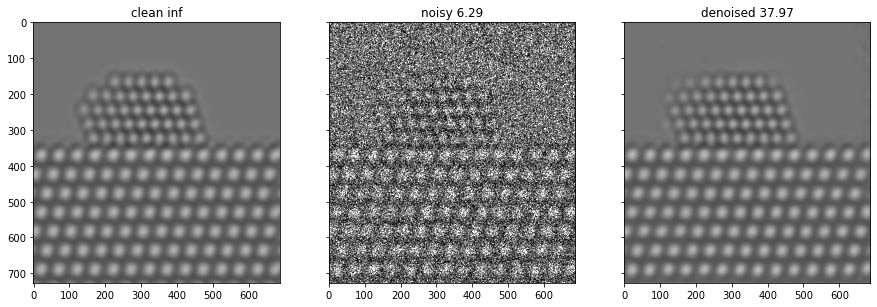

In [12]:
visualize_denoising([clean, noisy, denoised], vmax = 1.0, vmin = 0)

In [13]:
clean.shape

torch.Size([1, 1, 727, 687])

In [14]:
pixels = [(np.random.randint(100, 600), np.random.randint(400, 600)) for _ in range(10)]

# Guided Backpropagation

In [15]:
from torch.nn import ReLU

In [16]:
class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        first_layer = self.model.inc.double_conv[1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for module in self.model.modules():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, x, y, device=device):
        # Forward pass
        model_output = self.model(input_image)
        # Zero gradients
        self.model.zero_grad()
        # Backward pass
        model_output[0, 0, x, y].backward()
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.cpu().numpy()[0]
        return gradients_as_arr

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import copy

In [18]:
# denoise
noisy.requires_grad = True
denoised = net(noisy)

# guided backprop
GBP = GuidedBackprop(copy.deepcopy(net))

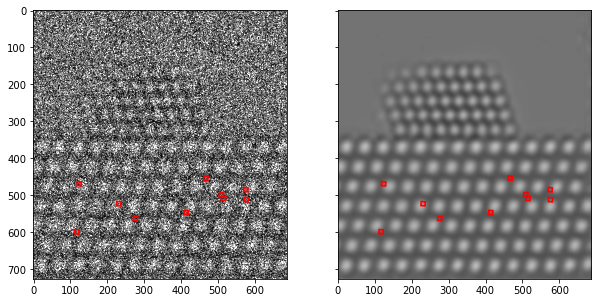

1 0.40067855 0.039136324 0.36154222


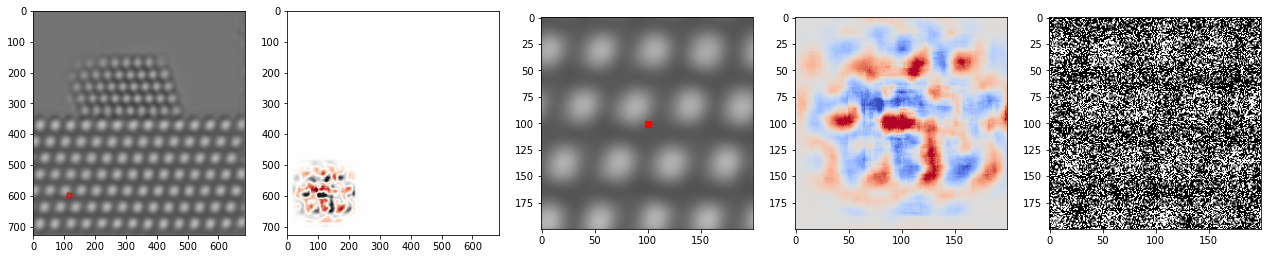

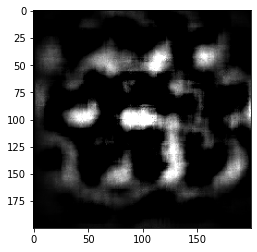

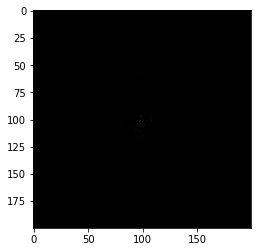

2 0.33363083 -0.025984373 0.3596152


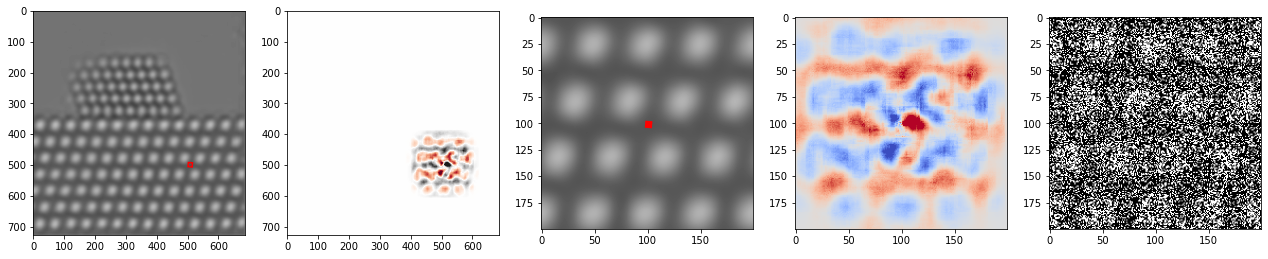

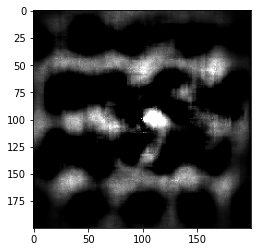

KeyboardInterrupt: 

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex = True, sharey = True, figsize = (10, 5))

# plot noisy
axes[0].imshow(noisy[0, 0].cpu().data.numpy(), 'gray', vmin = 0, vmax = 1)

# plot denoised
axes[1].imshow(denoised[0, 0].cpu().data.numpy(), 'gray', vmin = 0, vmax = 1)

for j, (ix, iy) in enumerate(pixels):
    pa1 = patches.Rectangle((ix,iy), width=2, height=2, angle=5, edgecolor = [1,0,0], facecolor='red', lw=5)
    pa2 = patches.Rectangle((ix,iy), width=2, height=2, angle=5, edgecolor = [1,0,0], facecolor='red', lw=5)
    axes[0].add_patch(pa1)
    axes[1].add_patch(pa2)

plt.show()

width = 100
photo_num = 0
for j, (ix, iy) in enumerate(pixels):
    
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize = (22, 6))
    
    im = axes[0].imshow(denoised[0, 0].cpu().data.numpy(), 'gray', vmin = 0, vmax = 1)
    
    
    filt = torch.autograd.grad(denoised[0,0,iy,ix], noisy, retain_graph=True)[0][0,0].cpu().data.numpy() 
    
    photo_num += 1
    print(photo_num, denoised[0, 0, iy, ix].cpu().data.numpy(), 
          np.sum(noisy.cpu().data.numpy()*filt), 
          denoised[0, 0, iy, ix].cpu().data.numpy() - np.sum(noisy.cpu().data.numpy()*filt) )
    
    limit =  max(np.abs(np.min( filt)), np.abs(np.max( filt)))
    limit /= 2
    im = axes[1].imshow(filt, 'RdGy', vmin= -limit, vmax = limit)
    
    axes[2].imshow(denoised[0, 0, iy-width:iy+width, ix-width:ix+width].cpu().data.numpy(), 'gray', vmin = 0, vmax = 1)
    axes[3].imshow(filt[iy-width:iy+width, ix-width:ix+width], 'coolwarm' if True else 'gray', vmin= -limit, vmax = limit)
    axes[4].imshow(noisy[0, 0, iy-width:iy+width, ix-width:ix+width].cpu().data.numpy(), 'gray', vmin = 0, vmax = 1)
    
    pa1 = patches.Rectangle((ix,iy), width=2, height=2, angle=5, edgecolor = [1,0,0], facecolor='red', lw=5)
    axes[0].add_patch(pa1)
    
    pa2 = patches.Rectangle( ( width, width) , 
                    width=2, height=2, angle=5, edgecolor = [1,0,0], facecolor='red', lw=5)
    axes[2].add_patch(pa2)
    
    plt.show()
    
    plt.imshow(filt[iy-width:iy+width, ix-width:ix+width], 'gray', vmin= 0, vmax = limit)
    plt.show()
    
    guided_grads = GBP.generate_gradients(copy.deepcopy(noisy), iy, ix, device)
    plt.imshow(guided_grads[0][iy-width:iy+width, ix-width:ix+width], cmap='gray', vmax = 0.0001, vmin = 0)
    
    plt.show()

# Plot

In [20]:
ix, iy = 205, 428

In [21]:
width = 100

In [22]:
linewidth = 3

([], [])

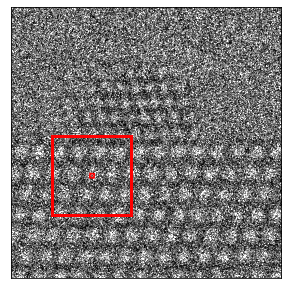

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex = False, sharey = False, figsize = (5, 5))
axes.imshow(noisy[0,0, :690, :690].data.cpu().numpy(), cmap='gray', vmax=1.0, vmin = 0.0)
pa1 = patches.Rectangle((ix,iy), width=2, height=2, angle=5, edgecolor = [1,0,0], facecolor='red', lw=5)
axes.add_patch(pa1)
rect1 = patches.Rectangle((ix-width,iy-width), width*2, width*2, linewidth= linewidth, edgecolor='red',facecolor='none')
axes.add_patch(rect1)
plt.xticks([])
plt.yticks([])
# plt.savefig('../images/jacobian/noisy.pdf', bbox_inches='tight', pad_inches = 0)

([], [])

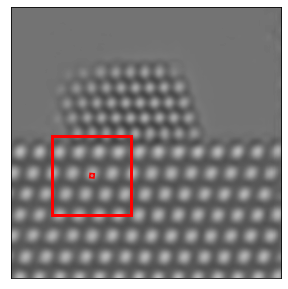

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex = False, sharey = False, figsize = (5, 5))
axes.imshow(denoised[0,0, :690, :690].data.cpu().numpy(), cmap='gray', vmax=1.0, vmin = 0.0)
pa1 = patches.Rectangle((ix,iy), width=2, height=2, angle=5, edgecolor = [1,0,0], facecolor='red', lw=5)
axes.add_patch(pa1)
rect1 = patches.Rectangle((ix-width,iy-width), width*2, width*2, linewidth= linewidth, edgecolor='red',facecolor='none')
axes.add_patch(rect1)
plt.xticks([])
plt.yticks([])
# plt.savefig('../images/jacobian/denoised.pdf', bbox_inches='tight', pad_inches = 0)

([], [])

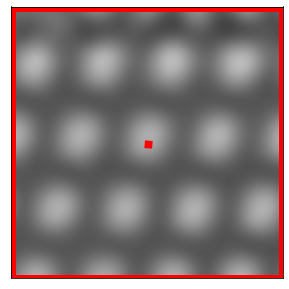

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex = False, sharey = False, figsize = (5, 5))
axes.imshow(denoised[0,0, iy-width:iy+width, ix-width:ix+width].data.cpu().numpy(), cmap='gray', vmax=1.0, vmin = 0.0)
pa1 = patches.Rectangle((width,width), width=2, height=2, angle=5, edgecolor = [1,0,0], facecolor='red', lw=5)
axes.add_patch(pa1)
rect1 = patches.Rectangle((0,0), width*2, width*2, linewidth= linewidth*3, edgecolor='red',facecolor='none')
axes.add_patch(rect1)
plt.xticks([])
plt.yticks([])
# plt.savefig('../images/jacobian/denoised_zoomed.pdf', bbox_inches='tight', pad_inches = 0)

In [26]:
filt = torch.autograd.grad(denoised[0,0,iy,ix], noisy, retain_graph=True)[0][0,0].cpu().data.numpy() 

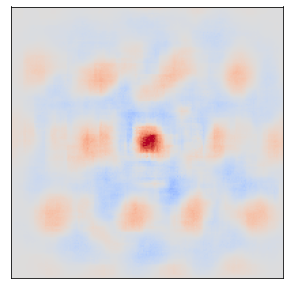

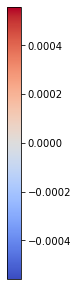

In [27]:
plt.figure(figsize = (5, 5))
limit = np.max(np.abs(filt[iy-width:iy+width, ix-width:ix+width]))
x = plt.imshow(filt[iy-width:iy+width, ix-width:ix+width], cmap='coolwarm', vmax = 0.8*limit, vmin=- 0.8* limit)
plt.xticks([])
plt.yticks([])
# plt.savefig('../images/jacobian/filter.pdf', bbox_inches='tight', pad_inches = 0)


# draw a new figure and replot the colorbar there
fig, ax = plt.subplots(figsize=(5,5))
cbar = plt.colorbar(x,ax=ax)
ax.remove()
# plt.savefig('../images/jacobian/filter_colorbar.pdf', bbox_inches='tight', pad_inches = 0)

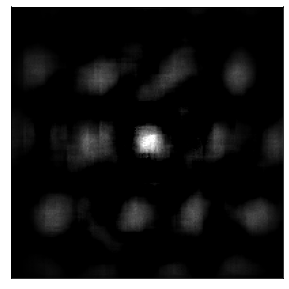

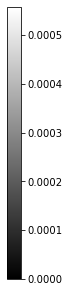

In [28]:
plt.figure(figsize = (5, 5))
limit = np.max(np.abs(filt[iy-width:iy+width, ix-width:ix+width]))
x = plt.imshow(filt[iy-width:iy+width, ix-width:ix+width], cmap='gray', vmax = 0.8*limit, vmin=0)
plt.xticks([])
plt.yticks([])
# plt.savefig('../images/jacobian/filter_thresholded.pdf', bbox_inches='tight', pad_inches = 0)

# draw a new figure and replot the colorbar there
fig, ax = plt.subplots(figsize=(5,5))
cbar = plt.colorbar(x,ax=ax)
ax.remove()
# plt.savefig('../images/jacobian/filter_thresholded_colorbar.pdf', bbox_inches='tight', pad_inches = 0)

In [29]:
guided_grads = GBP.generate_gradients(copy.deepcopy(noisy), iy, ix, device)

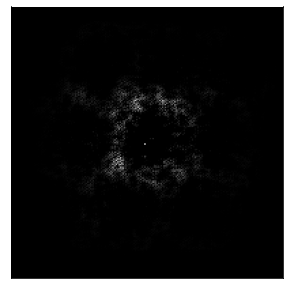

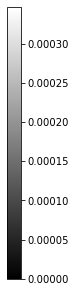

In [30]:
plt.figure(figsize = (5, 5))
x = plt.imshow(guided_grads[0][iy-width:iy+width, ix-width:ix+width], cmap='gray') # , vmax = 0.005, vmin=0
plt.xticks([])
plt.yticks([])
# plt.savefig('../images/jacobian/guided_backprop.pdf', bbox_inches='tight', pad_inches = 0)

# draw a new figure and replot the colorbar there
fig, ax = plt.subplots(figsize=(5,5))
cbar = plt.colorbar(x,ax=ax)
ax.remove()
# plt.savefig('../images/jacobian/guided_backprop_colorbar.pdf', bbox_inches='tight', pad_inches = 0)